# Create a Custom Dataset in Pytorch

This notebook demonsstrates how to create a pytorch custom dataset from a dataset hosted on [roboflow universe](https://universe.roboflow.com/).

First we need to install the roboflow python library and set our roboflow API key as an environment variable.

In [ ]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 120.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

## Get the Dataset

The dataset we are working with is the [poker cards dataset](https://universe.roboflow.com/roboflow-jvuqo/poker-cards-fmjio/dataset/4).

In [ ]:
from roboflow import download_dataset

dataset = download_dataset("https://universe.roboflow.com/roboflow-jvuqo/poker-cards-fmjio/dataset/4", "coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to poker-cards-4 in coco:: 100%|██████████| 907/907 [00:00<00:00, 4156.51it/s]


This would store the dataset in the directory poker-cards-4. The folder should look something like this:

```
poker-cards-4/
├── train/
│   ├── _annotations.coco.json
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ... (other image files)
├── valid/
│   ├── _annotations.coco.json
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ... (other image files)
└── test/
    ├── _annotations.coco.json
    ├── image1.jpg
    ├── image2.jpg
    └── ... (other image files)
```

## Creating the Custom PyTorch Dataset

In [4]:
import os
import json
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torchvision.transforms.functional as F


# --- Custom dataset ---
class PokerCardDataset(Dataset):
    def __init__(self, root_dir, transform=None, resize=None):
        self.root_dir = root_dir
        self.transform = transform
        self.resize = resize  # (H, W) tuple if resizing

        # Load COCO annotations
        ann_path = os.path.join(root_dir, "_annotations.coco.json")
        with open(ann_path, "r") as f:
            self.coco = json.load(f)

        # Map image_id -> image file
        self.images = {img["id"]: img for img in self.coco["images"]}

        # Collect annotations by image_id
        self.annotations = {}
        for ann in self.coco["annotations"]:
            img_id = ann["image_id"]
            if img_id not in self.annotations:
                self.annotations[img_id] = []
            self.annotations[img_id].append(ann)

        self.image_ids = list(self.images.keys())

        # Build category mapping {id: name}
        self.cat_id_to_name = {cat["id"]: cat["name"] for cat in self.coco["categories"]}

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.images[img_id]

        # Load image
        img_path = os.path.join(self.root_dir, img_info["file_name"])
        image = Image.open(img_path).convert("RGB")

        # Original size
        orig_w, orig_h = image.size

        # Load annotations
        anns = self.annotations.get(img_id, [])
        boxes, labels = [], []
        for ann in anns:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann["category_id"])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([img_id])}

        # Resize if specified
        if self.resize:
            new_h, new_w = self.resize
            image = F.resize(image, (new_h, new_w))

            scale_x = new_w / orig_w
            scale_y = new_h / orig_h
            boxes[:, [0, 2]] = boxes[:, [0, 2]] * scale_x
            boxes[:, [1, 3]] = boxes[:, [1, 3]] * scale_y
            target["boxes"] = boxes

        if self.transform:
            image = self.transform(image)

        return image, target

## Using the Custom Dataset

In [5]:
# --- Example usage ---
transform = transforms.ToTensor()
dataset = PokerCardDataset("poker-cards-4/train", transform=transform, resize=(256, 256))

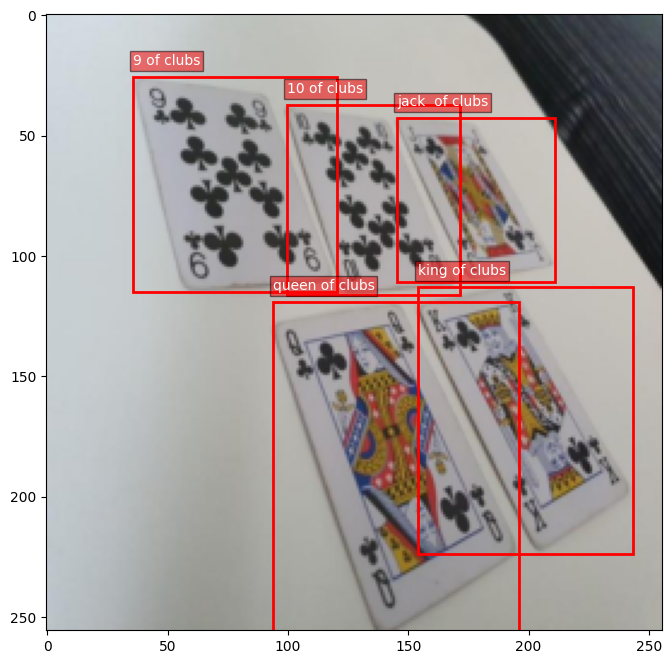

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Get a sample
image, target = dataset[0]

# Convert back to numpy for plotting
img_np = image.permute(1, 2, 0).numpy()

# Plot
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img_np)

for box, label in zip(target["boxes"], target["labels"]):
    x1, y1, x2, y2 = box
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor="red", facecolor="none"
    )
    ax.add_patch(rect)

    # Add label text
    class_name = dataset.cat_id_to_name[label.item()]
    ax.text(
        x1, y1 - 5, class_name,
        fontsize=10, color="white",
        bbox=dict(facecolor="red", alpha=0.5, pad=2)
    )

plt.show()

## Training the Model

Now we would train a Fast R-CNN Model on our custom dataset.

In [7]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torch.utils.data import DataLoader
import torchvision.transforms as T
import numpy as np


# 1. Define transforms
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor()
])

# 2. Create train and valid datasets
train_dataset = PokerCardDataset(root_dir="poker-cards-4/train", transform=transform)
valid_dataset = PokerCardDataset(root_dir="poker-cards-4/valid", transform=transform)

# 3. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# 4. Load pre-trained Faster R-CNN model
num_classes = len(train_dataset.coco["categories"]) + 1  # +1 for background
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# 5. Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 6. Define optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# 7. Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        total_loss += losses.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

# 8. Save model
torch.save(model.state_dict(), "fasterrcnn_pokercards.pth")
print("Training complete 🚀")


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 189MB/s]


Epoch 1/10, Loss: 393.9429
Epoch 2/10, Loss: 349.8507
Epoch 3/10, Loss: 277.9566
Epoch 4/10, Loss: 226.0536
Epoch 5/10, Loss: 193.7168
Epoch 6/10, Loss: 171.7934
Epoch 7/10, Loss: 154.5744
Epoch 8/10, Loss: 131.5548
Epoch 9/10, Loss: 123.8295
Epoch 10/10, Loss: 115.4250
Training complete 🚀


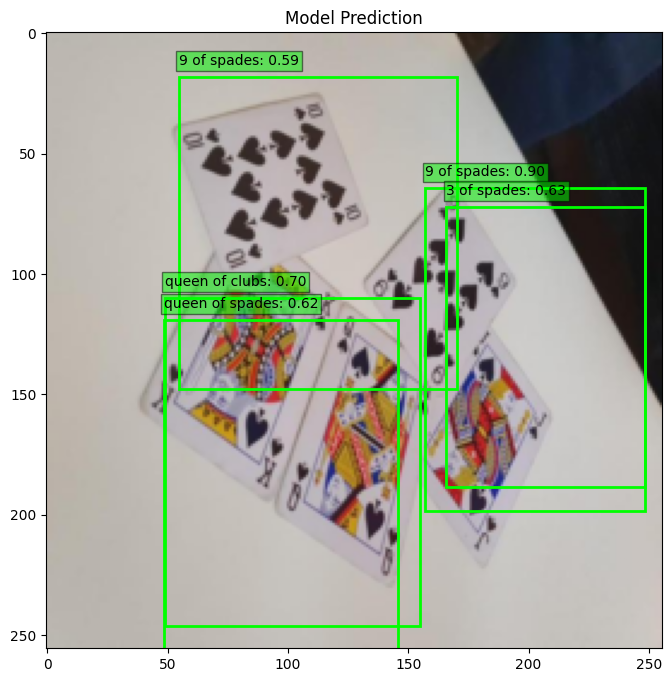

In [9]:
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- Load trained model for inference ---
model.eval()

# Pick one sample from the test set
test_dataset = PokerCardDataset("poker-cards-4/test", transform=transforms.ToTensor(), resize=(256, 256))
image, target = test_dataset[0]

# Add batch dimension and send to device
img_tensor = image.unsqueeze(0).to(device)

# Run inference
with torch.no_grad():
    prediction = model(img_tensor)

# Convert back to numpy for plotting
img_np = image.permute(1, 2, 0).numpy()

# Plot results
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img_np)
ax.set_title("Model Prediction")

# Get predicted boxes, labels, scores
pred_boxes = prediction[0]['boxes'].cpu()
pred_labels = prediction[0]['labels'].cpu()
pred_scores = prediction[0]['scores'].cpu()

# Draw only boxes above a confidence threshold
threshold = 0.5
for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
    if score < threshold:
        continue
    x1, y1, x2, y2 = box
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor="lime", facecolor="none"
    )
    ax.add_patch(rect)

    # Add label + score
    class_name = test_dataset.cat_id_to_name[label.item()]
    ax.text(
        x1, y1 - 5, f"{class_name}: {score:.2f}",
        fontsize=10, color="black",
        bbox=dict(facecolor="lime", alpha=0.5, pad=2)
    )

plt.show()